This is the main file for feature comparisons and hyperparameters optimization

In [1]:
# import functions
import importlib
import functions
importlib.reload(functions)
from functions import *

C:\Users\ytw\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ytw\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\ytw\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\ytw\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


import features

In [2]:
# import extracted features
baseline = pd.read_csv('features/baseline.csv')
fft = pd.read_csv('features/fft.csv')
ti = pd.read_csv('features/ti.csv')
rolloff = pd.read_csv('features/rolloff.csv')
spec = pd.read_csv('features/spec.csv')
wt = pd.read_csv('features/wavelets.csv')

pre-porcessing every features

In [3]:
baseline_X_train, y_train, baseline_X_test, y_test = pre_features(0.6, baseline)
fft_X_train, y_train, fft_X_test, y_test = pre_features(0.6, fft)
ti_X_train, y_train, ti_X_test, y_test = pre_features(0.6, ti)
rolloff_X_train, y_train, rolloff_X_test, y_test = pre_features(0.6, rolloff)
spec_X_train, y_train, spec_X_test, y_test = pre_features(0.6, spec)
wt_X_train, y_train, wt_X_test, y_test = pre_features(0.6, wt)

fit every feature by knn

In [4]:
# store result of all the features
result = {}

In [5]:
%%time
result['baseline cv'] = knn_cv(baseline_X_train, y_train, baseline_X_test, y_test, 5)
result['baseline'] = simple_knn(baseline_X_train, y_train, baseline_X_test, y_test)
result['fft cv'] = knn_cv(fft_X_train, y_train, fft_X_test, y_test, 5)
result['fft'] = simple_knn(fft_X_train, y_train, fft_X_test, y_test)
result['stft cv'] = knn_cv(ti_X_train, y_train, ti_X_test, y_test, 5)
result['stft'] = simple_knn(ti_X_train, y_train, ti_X_test, y_test)
result['rolloff cv'] = knn_cv(rolloff_X_train, y_train, rolloff_X_test, y_test, 5)
result['rolloff'] = simple_knn(rolloff_X_train, y_train, rolloff_X_test, y_test)
result['spec cv'] = knn_cv(spec_X_train, y_train, spec_X_test, y_test, 5)
result['spec'] = simple_knn(spec_X_train, y_train, spec_X_test, y_test)
result['wave cv'] = knn_cv(wt_X_train, y_train, wt_X_test, y_test, 5)
result['wave'] = simple_knn(wt_X_train, y_train, wt_X_test, y_test)

Wall time: 1min 56s


result

In [6]:
result_df = pd.DataFrame(list(result.items()), columns=['feature', 'F1'])
# change the format of result
result_table = {'feature': ['baseline', 'fft', 'ti', 'rolloff', 'spec', 'wavelet'],
        'cv score': list(result_df[result_df.index % 2 != 1]['F1']),
        'test score': list(result_df[result_df.index % 2 != 0]['F1'])}
table_df = pd.DataFrame(result_table)
table_df

,feature,cv score,test score
0,baseline,0.161490,0.159453
1,fft,0.686742,0.697011
2,ti,0.688802,0.695961
3,rolloff,0.327358,0.329341
4,spec,0.643502,0.643507
5,wavelet,0.593613,0.601099


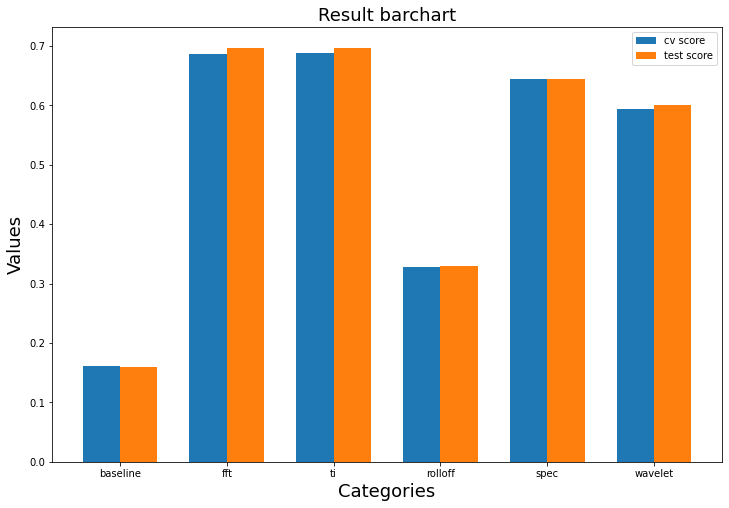

In [7]:
# display
plt.figure(figsize=(12, 8))
bar_width = 0.35
bar_positions = range(len(table_df['feature']))

plt.bar(bar_positions, table_df['cv score'], width=bar_width, label='cv score')
plt.bar([pos + bar_width for pos in bar_positions], table_df['test score'], width=bar_width, label='test score')

# Adding labels and title
plt.xlabel('Categories',fontsize=18)
plt.ylabel('Values',fontsize=18)
plt.title('Result barchart',fontsize=18)

# Adding legend
plt.legend()

# Adjusting x-axis ticks and labels
plt.xticks([pos + bar_width/2 for pos in bar_positions], table_df['feature'])

# Display the chart
plt.show()


looks like Temporal Integration is the best feature 

optimize the hyperparameters, number of neightbors and weights

In [8]:
%%time
ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
weights = ['uniform', 'distance']
grid_search_stft = grid_search_cv(ti_X_train, y_train, ns, weights, 5)

Wall time: 4min 27s


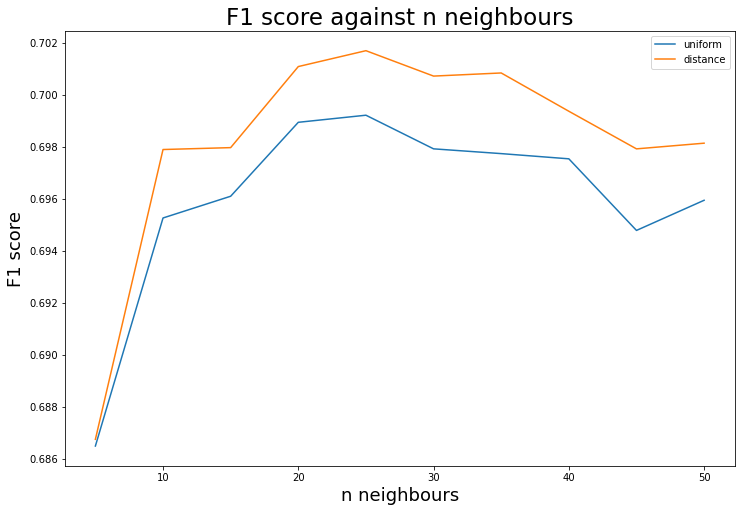

the best result of stft when use distance for n is 25, which is 0.7016941556633409


In [9]:
# print the curve
plt.figure(figsize=(12, 8))
plt.plot(ns, list(grid_search_stft.values())[0], label=weights[0])
plt.plot(ns, list(grid_search_stft.values())[1], label=weights[1])
plt.title('F1 score against n neighbours',fontsize=23)
plt.xlabel('n neighbours',fontsize=18)
plt.ylabel('F1 score',fontsize=18)
plt.legend()
plt.show()

# locate the best parameter
best_weight = max(grid_search_stft, key=lambda k: max(enumerate(grid_search_stft[k]), key=lambda x: x[1])[1])
best_n = ns[max(enumerate(grid_search_stft[best_weight]), key=lambda x: x[1])[0]]
max_result = max((max(lst) for lst in grid_search_stft.values()))

print(f'the best result of stft when use {best_weight} for n is {best_n}, which is {max_result}')

In [10]:
# the best model
knn_classifier = KNeighborsClassifier(n_neighbors=best_n, weights=best_weight)

# Train the classifier on the training data
knn_classifier.fit(ti_X_train, y_train)

# Make predictions 
y_pred_train = knn_classifier.predict(ti_X_train)
y_pred_test = knn_classifier.predict(ti_X_test)

# Evaluate the accuracy of the classifier
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print(f'Fitting F1 score on training set is {f1_train}, on testing set is {f1_test}.')

# check whether its overfitted
if f1_train > f1_test:
    print('The model is overfitted.')
else:
    print('The model is not overfitted.')

Fitting F1 score on training set is 1.0, on testing set is 0.7030983511013146.
The model is overfitted.
